In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import numpy
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

In [8]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ",len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  0


# Data preparation

image have amikacin and cefazolin 100 images in each type

In [10]:
#Organize data into train , valid , teset dirs
os.chdir('data/amikacin-cefazolin')
if os.path.isdir('train/amikacin') is False:
    os.makedirs('train/amikacin')
    os.makedirs('train/cefazolin')
    os.makedirs('valid/amikacin')
    os.makedirs('valid/cefazolin')
    os.makedirs('test/amikacin')
    os.makedirs('test/cefazolin')
    
    for c in random.sample(glob.glob("amikacin*"),80):
        shutil.move(c,'train/amikacin')
    for c in random.sample(glob.glob("cefazolin*"),80):
        shutil.move(c,'train/cefazolin')
    #for c in random.sample(glob.glob("amikacin*"),10):
    #    shutil.move(c,'valid/amikacin')
    #for c in random.sample(glob.glob("cefazolin*"),10):
    #    shutil.move(c,'valid/cefazolin')
    for c in random.sample(glob.glob("amikacin*"),20):
        shutil.move(c,'test/amikacin')
    for c in random.sample(glob.glob("cefazolin*"),20):
        shutil.move(c,'test/cefazolin')
os.chdir("../../")

In [21]:
train_path = 'data/amikacin-cefazolin/train'
valid_path = 'data/amikacin-cefazolin/valid'
test_path = 'data/amikacin-cefazolin/test'
                                            
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
	.flow_from_directory(directory=train_path,target_size=(224,224),classes=['amikacin','cefazolin'],batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
	.flow_from_directory(directory=valid_path,target_size=(224,224),classes=['amikacin','cefazolin'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
	.flow_from_directory(directory=test_path,target_size=(224,224),classes=['amikacin','cefazolin'],batch_size=10,shuffle=False)

Found 160 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [22]:
#Verified data
assert train_batches.n == 160
#assert valid_batches.n == 
assert test_batches.n == 40


In [23]:
imgs, labels = next(train_batches)

In [29]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are place
def plotImages (images_arr):
    fig, axes = plt.subplots(1,10, figsize= (20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


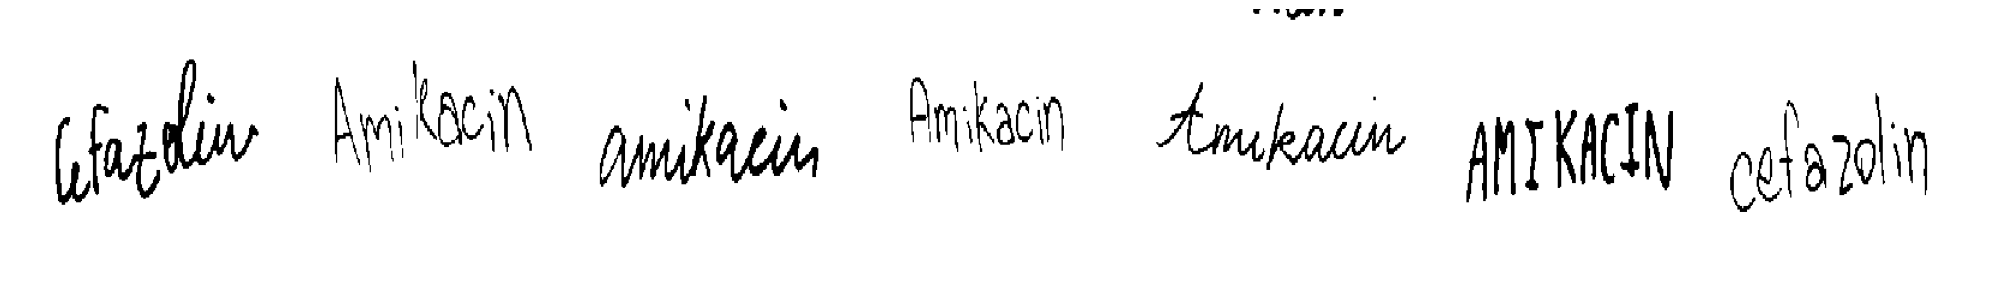

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [30]:
plotImages(imgs)
print(labels)

In [31]:
#in model.fit step per epoch = training sample/batches size
#e.g. 100/5 = 20 = step per epoch
#if pass validation data. we need to pass validation_steps


# Build and train CNN 

In [41]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation= 'relu', padding = 'same', input_shape= (224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation= 'relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    #units = output node (num_class)
    Dense(units=2, activation='softmax'),
    
])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy'])

In [45]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10
16/16 - 3s - loss: 195.4919 - accuracy: 0.5437 - 3s/epoch - 217ms/step
Epoch 2/10
16/16 - 3s - loss: 64.3906 - accuracy: 0.5562 - 3s/epoch - 167ms/step
Epoch 3/10
16/16 - 3s - loss: 15.4509 - accuracy: 0.7500 - 3s/epoch - 168ms/step
Epoch 4/10
16/16 - 3s - loss: 10.0384 - accuracy: 0.8125 - 3s/epoch - 168ms/step
Epoch 5/10
16/16 - 3s - loss: 4.2136 - accuracy: 0.9000 - 3s/epoch - 173ms/step
Epoch 6/10
16/16 - 3s - loss: 1.6913 - accuracy: 0.9750 - 3s/epoch - 170ms/step
Epoch 7/10
16/16 - 3s - loss: 0.1653 - accuracy: 0.9875 - 3s/epoch - 165ms/step
Epoch 8/10
16/16 - 3s - loss: 0.4244 - accuracy: 0.9750 - 3s/epoch - 167ms/step
Epoch 9/10
16/16 - 3s - loss: 0.3009 - accuracy: 0.9812 - 3s/epoch - 174ms/step
Epoch 10/10
16/16 - 3s - loss: 0.0111 - accuracy: 0.9937 - 3s/epoch - 169ms/step


# Predict